In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D, LayerNormalization, Softmax, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import Sequential, Model
import tensorflow_probability as tfp
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import backend as k 
import tensorflow_datasets as tfds
import PIL
from PIL import Image
import glob, os

In [35]:
folder = "C:\\Users\\samue\\Dropbox\\NeuroResearch\\noise-confidence refersal\\imagenet-sample-images-master\\imagenet-sample-images-master\\"

os.chdir(folder)

images_testing = np.zeros((1000,224,224,3))

c = 0
for file in glob.glob("*.jpeg"):
    image = Image.open(folder + file)
    arr = np.asarray(image)
    if len(np.shape(arr)) < 3:
        arr = arr[:,:,np.newaxis]
    arr = arr[::2,::2,:]
    arr_shape = np.shape(arr)
    arr_full = np.zeros((2000,2000,3))
    arr_full[:arr_shape[0],:arr_shape[1],:] = arr
    
    images_testing[c,:,:,:] = arr_full[:224,:224,:]
    c = c + 1
    


In [36]:
folder1 = "C:\\Users\\samue\\Dropbox\\NeuroResearch\\noise-confidence refersal\\imagenet-sample-images-master\\"


with open(folder1 + 'imagenet1000_clsidx_to_labels.txt','r') as inf:
    dict_from_file = eval(inf.read())

In [37]:
labels_testing = np.zeros((1000,1000))

c = 0
for file in glob.glob("*.jpeg"):
    file1 = file.split('_')[1]
    file1 = file1.split('.')[0]
    for i in range(len(dict_from_file)):
        if file1 in dict_from_file[i]:
            labels_testing[c,i] = 1
            break
        
        
        
    c = c + 1

In [38]:
images_testing = images_testing[:500]
labels_testing = labels_testing[:500]

In [39]:
def generate_gaussian_noise(images,noise_sd):
    #Adds random gaussian noise to images
    noisy_images = images + np.random.normal(0,noise_sd,np.shape(images))*256
    return noisy_images


def generate_contrast(images,a):
    
    contrasted_images = np.zeros(np.shape(images))
    #changes contrast based on alpha
    alpha = a
    for i in range(np.shape(images)[0]):
        for j in range(np.shape(images)[1]):
            for k in range(np.shape(images)[2]):
                if images[i,j,k] < 0.5:
                    contrasted_images[i,j,k] = 0.5*(2*images[i,j,k])**alpha
                    
                else:
                    contrasted_images[i,j,k] = 1 - 0.5*(2*(1-images[i,j,k]))**alpha
    
    return contrasted_images

def generate_pixel_dropout(images,dropout, replace=0.5):
    dropout_images = np.zeros(np.shape(images))

    for i in range(np.shape(images)[0]):
        for j in range(np.shape(images)[1]):
            for k in range(np.shape(images)[2]):
                if np.random.rand(1,)[0] < dropout:
                    dropout_images[i,j,k] = replace
                else:
                    dropout_images[i,j,k] = images[i,j,k]                       
                    
     
    
    return dropout_images

def display_images(images,n=10):
    #Displays first n images
    plt.figure(10000)
    fig, ax = plt.subplots(1,n,figsize=(15,15))
    for i in range(n):
        ax[i].imshow(images[i])  
    plt.show()
    
def compute_accuracy(actual_labels, predicted_labels):
    c = 0
    for i in range(len(actual_labels[:,0])):
        if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
            c = c+1
            
    return c/len(actual_labels[:,0])
        
def compute_confidence(actual_labels, predicted_labels):
    c = 0
    all_conf = 0 
    correct_conf = 0
    for i in range(len(actual_labels[:,0])):
        if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
            c = c+1
            correct_conf = predicted_labels[i,np.argmax(predicted_labels[i,:])] + correct_conf
        all_conf = predicted_labels[i,np.argmax(predicted_labels[i,:])] + all_conf
        
    if c==0:
        c=1
        
    all_conf = all_conf/len(actual_labels[:,0])
    correct_conf = correct_conf/c
    
    return all_conf,correct_conf

def compute_frequencies(predicted_labels):
    freq = np.zeros((10,1))
    for i in range(len(predicted_labels[:,0])): 
        freq[np.argmax(predicted_labels[i,:]),0] = 1 + freq[np.argmax(predicted_labels[i,:]),0]
        
    freq = freq/len(predicted_labels[:,0])
        
    return freq
        
    
def compute_confidence_by_category(actual_labels, predicted_labels):
    c = np.zeros((10,1))
    cc = np.zeros((10,1))
    all_conf = np.zeros((10,1))
    correct_conf = np.zeros((10,1))
    
    for j in range(10):
        for i in range(len(actual_labels[:,0])):
            if np.argmax(predicted_labels[i,:]) == j:
                cc[j] = cc[j] + 1
                if np.argmax(actual_labels[i,:]) == np.argmax(predicted_labels[i,:]):
                    c[j] = c[j]+1
                    correct_conf[j] = predicted_labels[i,np.argmax(predicted_labels[i,:])] + correct_conf[j]
                all_conf[j] = predicted_labels[i,np.argmax(predicted_labels[i,:])] + all_conf[j]

        all_conf[j] = all_conf[j]/cc[j]
        correct_conf[j] = correct_conf[j]/c[j]
    
    return all_conf,correct_conf

# Resnet

In [40]:
model = applications.ResNet152(weights = "imagenet", include_top=True, input_shape = (224, 224, 3))

16/16 [==============================] - 42s 3s/step


<Figure size 432x288 with 0 Axes>

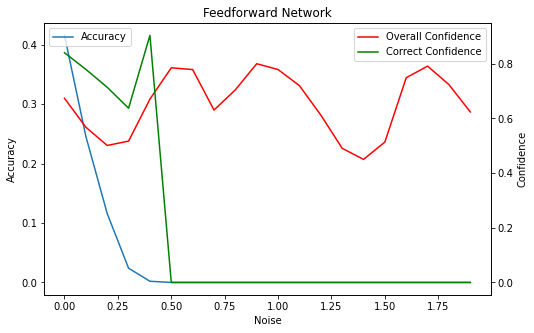

In [41]:
# Vary noise


sd_test = np.arange(0,2,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []




for i in range(len(sd_test)):
    images_testing_noise = generate_gaussian_noise(images_testing,sd_test[i])
    labels_testing_predicted = model.predict(images_testing_noise)
    

    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()




16/16 [==============================] - 38s 2s/step


<Figure size 432x288 with 0 Axes>

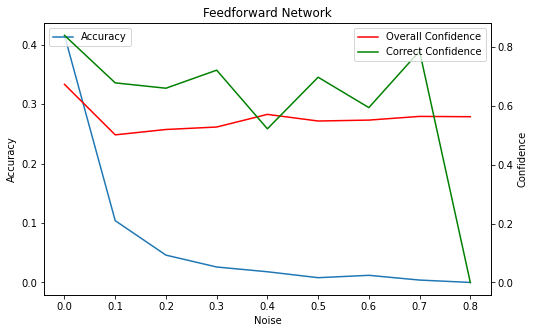

In [42]:
# Vary grey dropout


sd_test = np.arange(0,0.9,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []


activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0.5)
    labels_testing_predicted = model.predict(images_testing_noise)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()



16/16 [==============================] - 39s 2s/step


<Figure size 432x288 with 0 Axes>

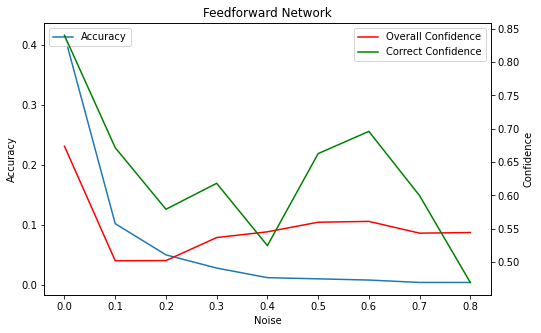

In [43]:
# Vary black dropout


sd_test = np.arange(0,0.9,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []


activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],0)
    labels_testing_predicted = model.predict(images_testing_noise)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()



16/16 [==============================] - 39s 2s/step


<Figure size 432x288 with 0 Axes>

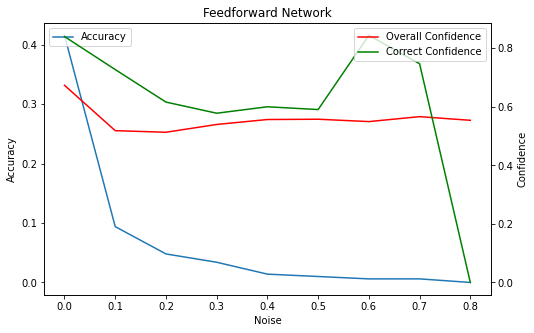

In [44]:
# Vary white dropout


sd_test = np.arange(0,0.9,.1)

all_conf_array = []
correct_conf_array = []
acc_array = []


activation_mean = []

for i in range(len(sd_test)):
    images_testing_noise = generate_pixel_dropout(images_testing,sd_test[i],1)
    labels_testing_predicted = model.predict(images_testing_noise)
    
    all_conf,correct_conf = compute_confidence(labels_testing,labels_testing_predicted)
    acc = compute_accuracy(labels_testing,labels_testing_predicted)
    
    all_conf_array.append(all_conf)
    correct_conf_array.append(correct_conf)   
    acc_array.append(acc)
    
    

plt.figure(1)
fig, acc_ax = plt.subplots(figsize=(8,5))
conf_ax = acc_ax.twinx()
acc_ax.set_xlabel("Noise")
acc_ax.set_ylabel("Accuracy")
conf_ax.set_ylabel("Confidence")
acc_ax.plot(sd_test,acc_array, label = "Accuracy")
conf_ax.plot(sd_test,all_conf_array, label = "Overall Confidence",color='r')
conf_ax.plot(sd_test,correct_conf_array, label = "Correct Confidence",color='g')
plt.title("Feedforward Network")
conf_ax.legend(loc= "upper right")
acc_ax.legend(loc= "upper left")
plt.show()

